In [ ]:
# Para instalar una versión específica que sabemos que funciona
!pip install mesa==1.1.1

In [ ]:
# 1) Instala dependencias
!pip install mesa nest_asyncio pyngrok

Estadísticas de tasa de infección por localidad:
                 mean       std       min       25%       50%       75%  \
Localidad                                                                
Chapiquina  0.000009  0.000006  0.000003  0.000006  0.000008  0.000011   
Socoroma    0.010018  0.006732  0.002715  0.005026  0.008428  0.012416   
Ticnamar    0.001667  0.000853  0.000745  0.001070  0.001530  0.001758   

                 max  
Localidad             
Chapiquina  0.000021  
Socoroma    0.023525  
Ticnamar    0.003490  


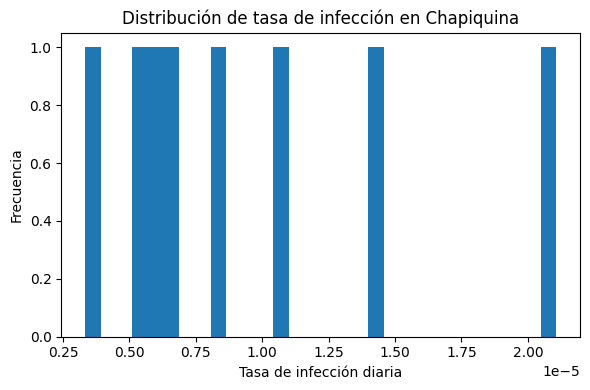

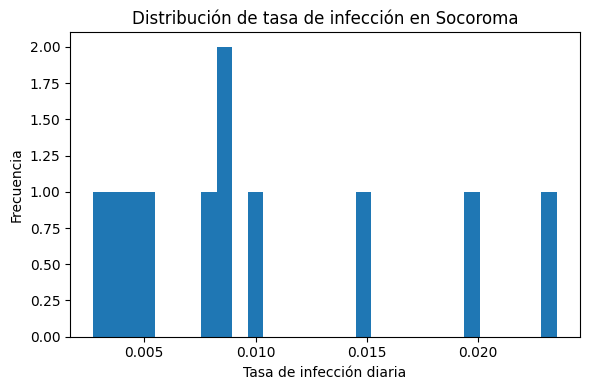

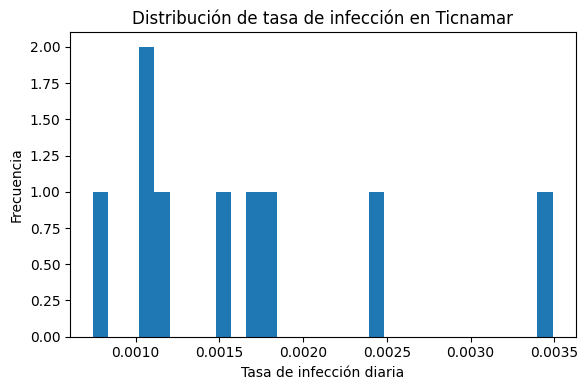

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros de la función de infección (consistentes con tu modelo) ---
T_opt     = 20.0
sigma_T   = 3.0
H50       = 5.0
n_hill    = 3.0
r_max     = 0.8
P_opt     = 705.0
sigma_P   = 5.0
R50       = 15.0
W50       = 5.0

def rate_of_infection(temp, hum, pres, rad, wind):
    # temperatura
    tf = np.exp(-((temp - T_opt)**2)/(2*sigma_T**2))
    # humedad
    hr = (hum / H50)**n_hill
    hf = hr / (1 + hr)
    # presión
    pf = np.exp(-((pres - P_opt)**2)/(2*sigma_P**2))
    # radiación
    rf = (rad / R50) / (1 + rad / R50)
    # viento (inhibidor)
    wf = 1 / (1 + wind / W50)
    return np.clip(r_max * tf * hf * pf * rf * wf, 0, 1)

# --- Carga de datos ---
df = pd.read_csv('datos_meteorologia_limpio_tres_localidades.csv')
df = df.dropna(subset=[
    'Temperatura del Aire ºC',
    'Humedad Relativa %',
    'Presión Atmosférica mbar',
    'Radiación Solar Mj/m²',
    'Velocidad de Viento km/h'
])

# --- Cálculo de tasa diaria ---
df['rate'] = df.apply(lambda row: rate_of_infection(
    row['Temperatura del Aire ºC'],
    row['Humedad Relativa %'],
    row['Presión Atmosférica mbar'],
    row['Radiación Solar Mj/m²'],
    row['Velocidad de Viento km/h']
), axis=1)

# --- Tabla resumen por localidad ---
summary = df.groupby('Localidad')['rate'].describe()[['mean','std','min','25%','50%','75%','max']]
print("Estadísticas de tasa de infección por localidad:\n", summary)

# --- Histogramas de tasa por localidad ---
for loc, grp in df.groupby('Localidad'):
    plt.figure(figsize=(6,4))
    plt.hist(grp['rate'], bins=30)
    plt.title(f'Distribución de tasa de infección en {loc}')
    plt.xlabel('Tasa de infección diaria')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()


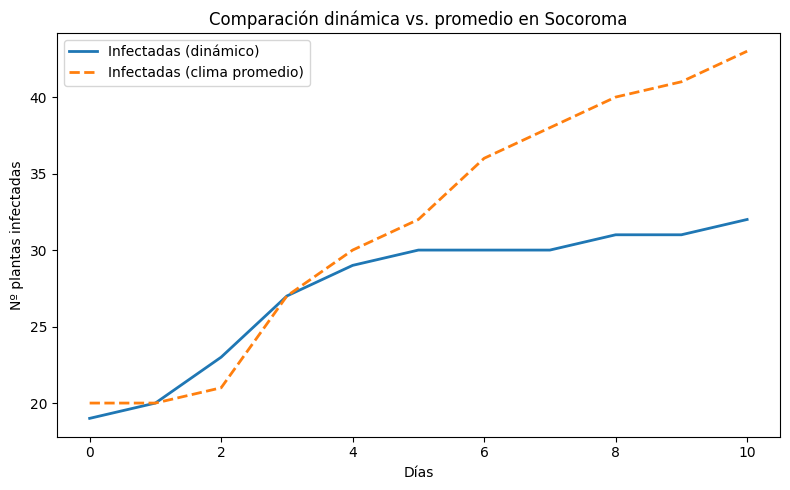

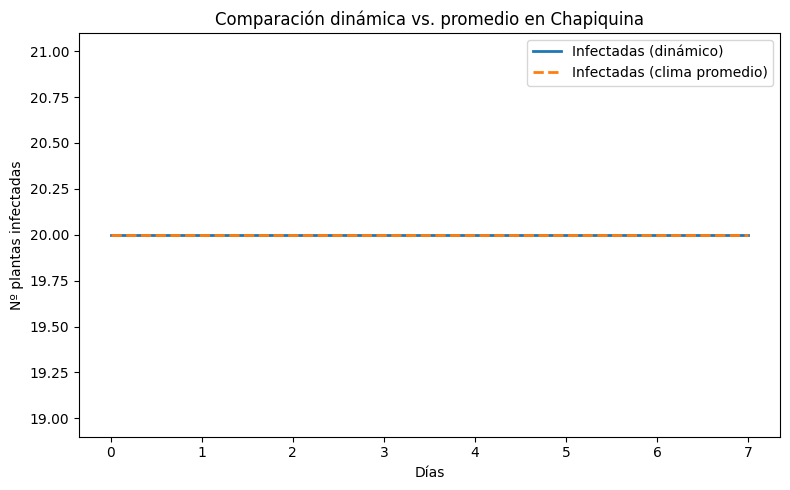

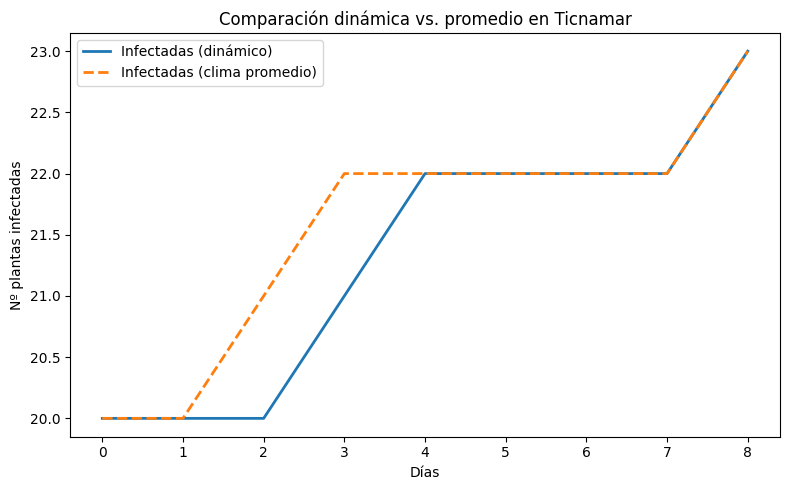

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- Parámetros generales ---
CSV_PATH = 'datos_meteorologia_limpio_tres_localidades.csv'
GRID_H, GRID_W   = 50, 50
PLANT_DENSITY    = 0.8
INITIAL_INF_FRAC = 0.01

# --- Función de tasa de infección con todas las variables ---
T_opt, sigma_T, n_hill, r_max = 20.0, 3.0, 3.0, 0.7
P_opt, sigma_P = 705.0, 5.0
R50, W50        = 15.0, 5.0

def rate_of_infection(temp, hum, pres, rad, wind):
    tf = np.exp(-((temp - T_opt)**2)/(2*sigma_T**2))
    hr = (hum / H50)**n_hill; hf = hr/(1+hr)
    pf = np.exp(-((pres - P_opt)**2)/(2*sigma_P**2))
    rf = (rad / R50)/(1 + rad/R50)
    wf = 1/(1 + wind/W50)
    return np.clip(r_max * tf * hf * pf * rf * wf, 0, 1)

# --- Mortalidad crónica ---
threshold_days = 30
base_mort, max_mort = 0.001, 0.1

# --- Modelo generalizado ---
def run_model(df_loc, infection_radius, use_static=False, static_vals=None):
    days_total = len(df_loc)
    # Inicializa
    state     = np.zeros((GRID_H, GRID_W), int)
    days_inf  = np.zeros_like(state)
    mask      = np.random.rand(GRID_H, GRID_W) < PLANT_DENSITY
    state[mask] = 1
    # semilla infectada
    healthy_idxs = np.argwhere(state==1)
    k0 = max(1, int(len(healthy_idxs)*INITIAL_INF_FRAC))
    for idx in healthy_idxs[np.random.choice(len(healthy_idxs), k0, replace=False)]:
        state[tuple(idx)] = 2

    H, I, D = [], [], []
    coords = np.dstack(np.indices(state.shape)).reshape(-1,2)

    # valores estáticos si aplica
    if use_static:
        temp, hum, pres, rad, wind = static_vals

    for day in range(days_total):
        if not use_static:
            row  = df_loc.iloc[day]
            temp = row['Temperatura del Aire ºC']
            hum  = row['Humedad Relativa %']
            pres = row['Presión Atmosférica mbar']
            rad  = row['Radiación Solar Mj/m²']
            wind = row['Velocidad de Viento km/h']

        rate = rate_of_infection(temp, hum, pres, rad, wind)

        # recuento
        H.append((state==1).sum())
        I.append((state==2).sum())
        D.append((state==3).sum())

        # propagación
        for (r, c) in np.argwhere(state==2):
            dists = cdist([(r,c)], coords).reshape(state.shape)
            mask_inf = (dists <= infection_radius) & (state==1)
            rnd = np.random.rand(GRID_H, GRID_W)
            new_inf = (rnd < rate) & mask_inf
            state[new_inf] = 2; days_inf[new_inf] = 0

        days_inf[state==2] += 1

        # mortalidad crónica
        mort_prob = np.where(
            days_inf >= threshold_days,
            np.clip(base_mort * (days_inf/threshold_days), 0, max_mort),
            0.0
        )
        die = (np.random.rand(GRID_H, GRID_W) < mort_prob) & (state==2)
        state[die] = 3

    return np.array(H), np.array(I), np.array(D)

# --- Carga y cálculo de promedios ---
df = pd.read_csv(CSV_PATH).dropna(subset=[
    'Temperatura del Aire ºC','Humedad Relativa %','Presión Atmosférica mbar',
    'Radiación Solar Mj/m²','Velocidad de Viento km/h'
])

# medias históricas por localidad
cols = ['Temperatura del Aire ºC','Humedad Relativa %',
        'Presión Atmosférica mbar','Radiación Solar Mj/m²','Velocidad de Viento km/h']
medias = df.groupby('Localidad')[cols].mean()

# --- Simulación y gráfica comparativa ---
infection_radius = 2.0
for loc in df['Localidad'].unique():
    df_loc = df[df['Localidad']==loc].reset_index(drop=True)
    static_vals = medias.loc[loc].values

    # dinámica vs estático
    H_dyn, I_dyn, D_dyn = run_model(df_loc, infection_radius, use_static=False)
    H_sta, I_sta, D_sta = run_model(df_loc, infection_radius, use_static=True, static_vals=static_vals)

    days = np.arange(len(H_dyn))

    plt.figure(figsize=(8,5))
    plt.plot(days, I_dyn, label='Infectadas (dinámico)', lw=2)
    plt.plot(days, I_sta, label='Infectadas (clima promedio)', lw=2, ls='--')
    plt.xlabel('Días')
    plt.ylabel('Nº plantas infectadas')
    plt.title(f'Comparación dinámica vs. promedio en {loc}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import display # Import display function


# --- Parámetros generales ---
CSV_PATH = 'datos_meteorologia_limpio_tres_localidades.csv'
GRID_H, GRID_W   = 50, 50
PLANT_DENSITY    = 0.8
INITIAL_INF_FRAC = 0.01

# --- Parámetros de la función de infección ---
T_opt, sigma_T, H50, n_hill, r_max = 20.0, 3.0, 8.0, 3.0, 0.7
P_opt, sigma_P = 705.0, 5.0
R50, W50        = 15.0, 5.0

def rate_of_infection(temp, hum, pres, rad, wind):
    tf = np.exp(-((temp - T_opt)**2)/(2*sigma_T**2))
    hr = (hum / H50)**n_hill; hf = hr/(1+hr)
    pf = np.exp(-((pres - P_opt)**2)/(2*sigma_P**2))
    rf = (rad / R50)/(1 + rad/R50)
    wf = 1/(1 + wind/W50)
    return np.clip(r_max * tf * hf * pf * rf * wf, 0, 1)

# --- Mortalidad crónica ---
threshold_days = 30
base_mortality, max_mortality = 0.001, 0.1

# --- Modelo generalizado ---
def run_model(df_loc, infection_radius, use_static=False, static_vals=None):
    days_total = len(df_loc)
    state     = np.zeros((GRID_H, GRID_W), int)
    days_inf  = np.zeros_like(state)
    mask      = np.random.rand(GRID_H, GRID_W) < PLANT_DENSITY
    state[mask] = 1
    healthy_idxs = np.argwhere(state==1)
    k0 = max(1, int(len(healthy_idxs)*INITIAL_INF_FRAC))
    for idx in healthy_idxs[np.random.choice(len(healthy_idxs), k0, replace=False)]:
        state[tuple(idx)] = 2

    H, I, D = [], [], []
    coords = np.dstack(np.indices(state.shape)).reshape(-1,2)

    if use_static:
        temp, hum, pres, rad, wind = static_vals

    for day in range(days_total):
        if not use_static:
            row = df_loc.iloc[day]
            temp, hum = row['Temperatura del Aire ºC'], row['Humedad Relativa %']
            pres = row['Presión Atmosférica mbar']
            rad  = row['Radiación Solar Mj/m²']
            wind = row['Velocidad de Viento km/h']
        rate = rate_of_infection(temp, hum, pres, rad, wind)

        H.append((state==1).sum())
        I.append((state==2).sum())
        D.append((state==3).sum())

        for (r, c) in np.argwhere(state==2):
            dists = cdist([(r,c)], coords).reshape(state.shape)
            mask_inf = (dists <= infection_radius) & (state==1)
            rand = np.random.rand(GRID_H, GRID_W)
            new_inf = (rand < rate) & mask_inf
            state[new_inf] = 2; days_inf[new_inf] = 0

        days_inf[state==2] += 1

        mort_prob = np.where(
            days_inf >= threshold_days,
            np.clip(base_mortality * (days_inf/threshold_days), 0, max_mortality),
            0.0
        )
        die = (np.random.rand(GRID_H, GRID_W) < mort_prob) & (state==2)
        state[die] = 3

    return np.array(H), np.array(I), np.array(D)

# --- Carga y cálculo de promedios ---
df = pd.read_csv(CSV_PATH).dropna(subset=[
    'Temperatura del Aire ºC','Humedad Relativa %',
    'Presión Atmosférica mbar','Radiación Solar Mj/m²','Velocidad de Viento km/h'
])
cols = ['Temperatura del Aire ºC','Humedad Relativa %',
        'Presión Atmosférica mbar','Radiación Solar Mj/m²','Velocidad de Viento km/h']
medias = df.groupby('Localidad')[cols].mean()

# --- Simulación y métricas ---
infection_radius = 2.0
results = []
for loc in df['Localidad'].unique():
    df_loc     = df[df['Localidad']==loc].reset_index(drop=True)
    static_vals= medias.loc[loc].values
    _, I_dyn, _ = run_model(df_loc, infection_radius, use_static=False)
    _, I_sta, _ = run_model(df_loc, infection_radius, use_static=True, static_vals=static_vals)
    results.append({
        'Localidad': loc,
        'Pico_dyn': int(I_dyn.max()),
        'Día_pico_dyn': int(I_dyn.argmax()),
        'AUC_dyn': float(np.trapz(I_dyn)),
        'Pico_sta': int(I_sta.max()),
        'Día_pico_sta': int(I_sta.argmax()),
        'AUC_sta': float(np.trapz(I_sta)),
    })

df_metrics = pd.DataFrame(results)
# Use the imported display function instead of the undefined one
print('Métricas dinámico vs. promedio')
display(df_metrics)

<ipython-input-4-3202088679>:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'AUC_dyn': float(np.trapz(I_dyn)),
<ipython-input-4-3202088679>:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'AUC_sta': float(np.trapz(I_sta)),


Métricas dinámico vs. promedio


,Localidad,Pico_dyn,Día_pico_dyn,AUC_dyn,Pico_sta,Día_pico_sta,AUC_sta
0,Socoroma,50,10,355.0,26,10,237.0
1,Chapiquina,21,6,141.5,19,0,133.0
2,Ticnamar,20,0,160.0,20,0,160.0


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import display # Import display function


# --- Parámetros generales ---
CSV_PATH = 'datos_meteorologia_limpio_tres_localidades.csv'
GRID_H, GRID_W   = 50, 50
PLANT_DENSITY    = 0.8
INITIAL_INF_FRAC = 0.01

# --- Parámetros de la función de infección ---
T_opt, sigma_T, H50, n_hill, r_max = 20.0, 3.0, 8.0, 3.0, 0.7
P_opt, sigma_P = 705.0, 5.0
R50, W50        = 15.0, 5.0

def rate_of_infection(temp, hum, pres, rad, wind):
    tf = np.exp(-((temp - T_opt)**2)/(2*sigma_T**2))
    hr = (hum / H50)**n_hill; hf = hr/(1+hr)
    pf = np.exp(-((pres - P_opt)**2)/(2*sigma_P**2))
    rf = (rad / R50)/(1 + rad/R50)
    wf = 1/(1 + wind/W50)
    return np.clip(r_max * tf * hf * pf * rf * wf, 0, 1)

# --- Mortalidad crónica ---
threshold_days = 15
base_mortality, max_mortality = 0.001, 0.1

# --- Modelo generalizado ---
def run_model(df_loc, infection_radius, use_static=False, static_vals=None):
    days_total = len(df_loc)
    state     = np.zeros((GRID_H, GRID_W), int)
    days_inf  = np.zeros_like(state)
    mask      = np.random.rand(GRID_H, GRID_W) < PLANT_DENSITY
    state[mask] = 1
    healthy_idxs = np.argwhere(state==1)
    k0 = max(1, int(len(healthy_idxs)*INITIAL_INF_FRAC))
    for idx in healthy_idxs[np.random.choice(len(healthy_idxs), k0, replace=False)]:
        state[tuple(idx)] = 2

    H, I, D = [], [], []
    coords = np.dstack(np.indices(state.shape)).reshape(-1,2)

    if use_static:
        temp, hum, pres, rad, wind = static_vals

    for day in range(days_total):
        if not use_static:
            row = df_loc.iloc[day]
            temp, hum = row['Temperatura del Aire ºC'], row['Humedad Relativa %']
            pres = row['Presión Atmosférica mbar']
            rad  = row['Radiación Solar Mj/m²']
            wind = row['Velocidad de Viento km/h']
        rate = rate_of_infection(temp, hum, pres, rad, wind)

        H.append((state==1).sum())
        I.append((state==2).sum())
        D.append((state==3).sum())

        for (r, c) in np.argwhere(state==2):
            dists = cdist([(r,c)], coords).reshape(state.shape)
            mask_inf = (dists <= infection_radius) & (state==1)
            rand = np.random.rand(GRID_H, GRID_W)
            new_inf = (rand < rate) & mask_inf
            state[new_inf] = 2; days_inf[new_inf] = 0

        days_inf[state==2] += 1

        mort_prob = np.where(
            days_inf >= threshold_days,
            np.clip(base_mortality * (days_inf/threshold_days), 0, max_mortality),
            0.0
        )
        die = (np.random.rand(GRID_H, GRID_W) < mort_prob) & (state==2)
        state[die] = 3

    return np.array(H), np.array(I), np.array(D)

# --- Carga y cálculo de promedios ---
df = pd.read_csv(CSV_PATH).dropna(subset=[
    'Temperatura del Aire ºC','Humedad Relativa %',
    'Presión Atmosférica mbar','Radiación Solar Mj/m²','Velocidad de Viento km/h'
])
cols = ['Temperatura del Aire ºC','Humedad Relativa %',
        'Presión Atmosférica mbar','Radiación Solar Mj/m²','Velocidad de Viento km/h']
medias = df.groupby('Localidad')[cols].mean()

# --- Simulación y métricas ---
infection_radius = 2.0
results = []
for loc in df['Localidad'].unique():
    df_loc     = df[df['Localidad']==loc].reset_index(drop=True)
    static_vals= medias.loc[loc].values
    _, I_dyn, _ = run_model(df_loc, infection_radius, use_static=False)
    _, I_sta, _ = run_model(df_loc, infection_radius, use_static=True, static_vals=static_vals)
    results.append({
        'Localidad': loc,
        'Pico_dyn': int(I_dyn.max()),
        'Día_pico_dyn': int(I_dyn.argmax()),
        'AUC_dyn': float(np.trapz(I_dyn)),
        'Pico_sta': int(I_sta.max()),
        'Día_pico_sta': int(I_sta.argmax()),
        'AUC_sta': float(np.trapz(I_sta)),
    })

df_metrics = pd.DataFrame(results)
# Use the imported display function instead of the undefined one
print('Métricas dinámico vs. promedio')
display(df_metrics)

Métricas dinámico vs. promedio


<ipython-input-5-1661158699>:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'AUC_dyn': float(np.trapz(I_dyn)),
<ipython-input-5-1661158699>:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'AUC_sta': float(np.trapz(I_sta)),


,Localidad,Pico_dyn,Día_pico_dyn,AUC_dyn,Pico_sta,Día_pico_sta,AUC_sta
0,Socoroma,40,10,328.0,43,10,313.5
1,Chapiquina,19,0,133.0,19,0,133.0
2,Ticnamar,20,5,155.5,25,7,179.0


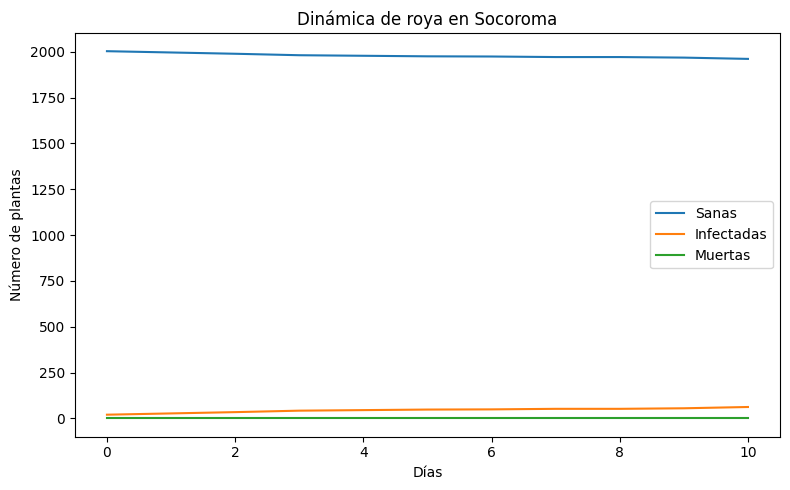

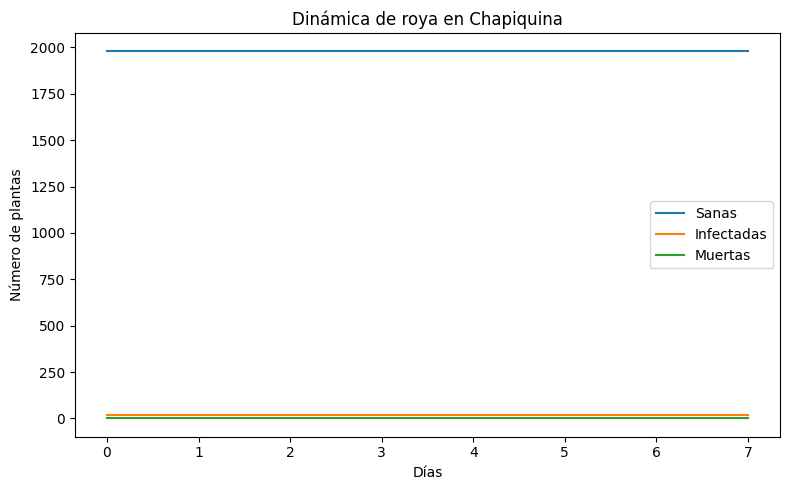

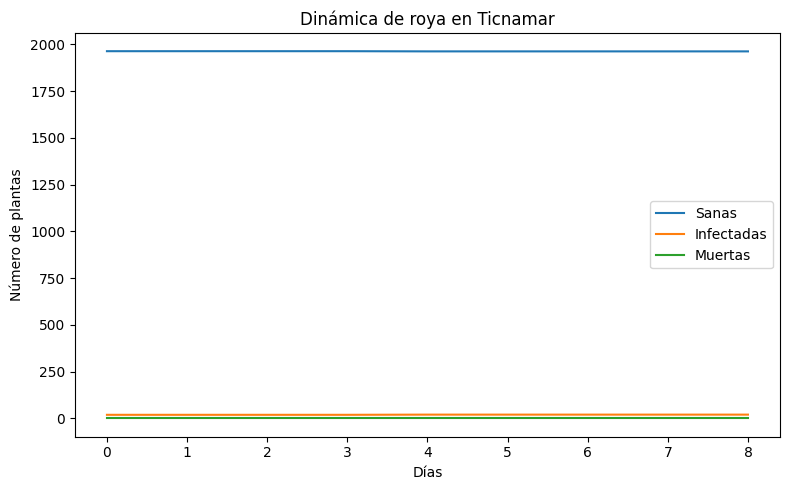

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- Parámetros del modelo ---
CSV_PATH = 'datos_meteorologia_limpio_tres_localidades.csv'
GRID_WIDTH = 50           # columnas
GRID_HEIGHT = 50          # filas
PLANT_DENSITY = 0.8       # fracción de celdas con plantas
INITIAL_INF_FRAC = 0.01   # fracción inicial infectada

# Parámetros de la función de infección
T_opt     = 20.0
sigma_T   = 3.0
H50       = 2.0
n_hill    = 3.0
r_max     = 1.0
# presión
P_opt     = 705.0     # presión óptima (mbar)
sigma_P   = 5.0       # ancho de la campana de presión
# radiación
R50       = 15.0      # radiación al 50% (Mj/m²)
# viento
W50       = 5.0       # viento al 50% (km/h)

infection_radius = 2.0    # radio básico de infección (euclidiano)

# Parámetros de mortalidad crónica
threshold_days = 15      # días tras los cuales aumenta mortalidad
base_mortality = 0.01    # probabilidad diaria inicial
max_mortality  = 0.6      # probabilidad diaria máxima

# --- Función tasa de infección usando todas las variables ---
def rate_of_infection(temp, hum, pres, rad, wind):
    # temperatura (Gaussiana)
    tf = np.exp(-((temp - T_opt)**2)/(2*sigma_T**2))
    # humedad (Hill)
    hr = (hum / H50)**n_hill
    hf = hr / (1 + hr)
    # presión (Gaussiana)
    pf = np.exp(-((pres - P_opt)**2)/(2*sigma_P**2))
    # radiación (Hill)
    rf = (rad / R50) / (1 + rad / R50)
    # viento (inhibidor: más viento, menos infección)
    wf = 1 / (1 + wind / W50)
    # combinación
    rate = r_max * tf * hf * pf * rf * wf
    return np.clip(rate, 0, 1)

# --- Carga de datos ---
df = pd.read_csv(CSV_PATH)
# Asegurarse que no haya NaN en las columnas usadas
df = df.dropna(subset=[
    'Temperatura del Aire ºC',
    'Humedad Relativa %',
    'Presión Atmosférica mbar',
    'Radiación Solar Mj/m²',
    'Velocidad de Viento km/h'
])

localidades = df['Localidad'].unique()

for loc in localidades:
    df_loc = df[df['Localidad'] == loc].reset_index(drop=True)
    days_total = len(df_loc)

    # Estado inicial de la cuadrícula
    state = np.zeros((GRID_HEIGHT, GRID_WIDTH), dtype=int)
    days_inf = np.zeros_like(state)

    # Plantación aleatoria
    mask = np.random.rand(GRID_HEIGHT, GRID_WIDTH) < PLANT_DENSITY
    state[mask] = 1
    total_plants = state.sum()

    # Infectar semilla
    n0 = max(1, int(total_plants * INITIAL_INF_FRAC))
    healthy_positions = np.argwhere(state == 1)
    init_idx = np.random.choice(len(healthy_positions), n0, replace=False)
    for idx in init_idx:
        r, c = healthy_positions[idx]
        state[r, c] = 2

    # Para recolectar series
    H_hist, I_hist, D_hist = [], [], []
    coords = np.dstack(np.indices(state.shape)).reshape(-1,2)

    # Loop diario
    for day in range(days_total):
        row = df_loc.iloc[day]
        temp = row['Temperatura del Aire ºC']
        hum  = row['Humedad Relativa %']
        pres = row['Presión Atmosférica mbar']
        rad  = row['Radiación Solar Mj/m²']
        wind = row['Velocidad de Viento km/h']

        # calcular tasa usando todas las variables
        rate = rate_of_infection(temp, hum, pres, rad, wind)

        # registrar estados
        H_hist.append((state == 1).sum())
        I_hist.append((state == 2).sum())
        D_hist.append((state == 3).sum())

        # propagación
        for (r,c) in np.argwhere(state == 2):
            dists = cdist([(r,c)], coords).reshape(state.shape)
            mask_inf = (dists <= infection_radius) & (state == 1)
            rnd = np.random.rand(GRID_HEIGHT, GRID_WIDTH)
            new_inf = (rnd < rate) & mask_inf
            days_inf[new_inf] = 0
            state[new_inf] = 2

        # aumentar días infectado
        days_inf[state == 2] += 1

        # mortalidad crónica
        mort_prob = np.where(
            days_inf >= threshold_days,
            np.clip(base_mortality * (days_inf/threshold_days), 0, max_mortality),
            0.0
        )
        die_rand = np.random.rand(GRID_HEIGHT, GRID_WIDTH)
        to_die = (die_rand < mort_prob) & (state == 2)
        state[to_die] = 3

    # --- Graficar por localidad ---
    days = np.arange(days_total)
    plt.figure(figsize=(8,5))
    plt.plot(days, H_hist, label='Sanas')
    plt.plot(days, I_hist, label='Infectadas')
    plt.plot(days, D_hist, label='Muertas')
    plt.xlabel('Días')
    plt.ylabel('Número de plantas')
    plt.title(f'Dinámica de roya en {loc}')
    plt.legend()
    plt.tight_layout()
    plt.show()



>>> Socoroma <<<


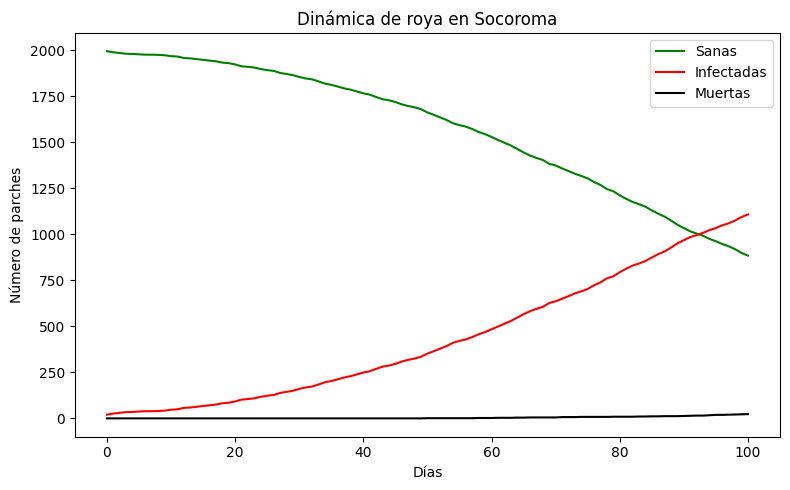


>>> Chapiquina <<<


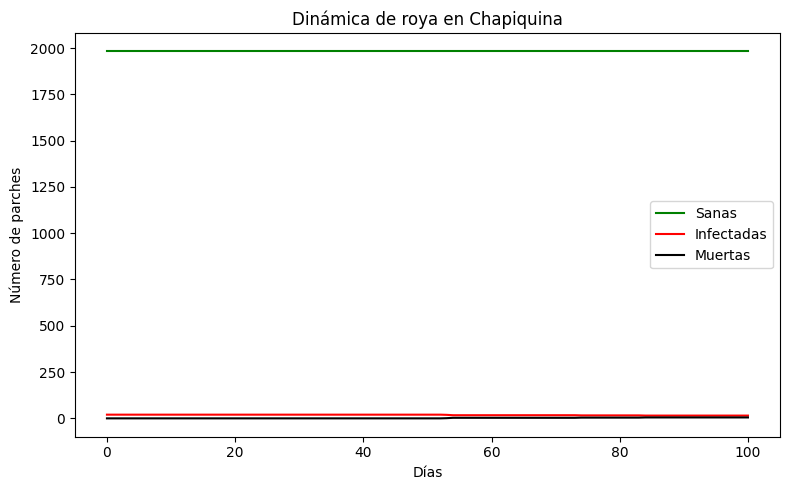


>>> Ticnamar <<<


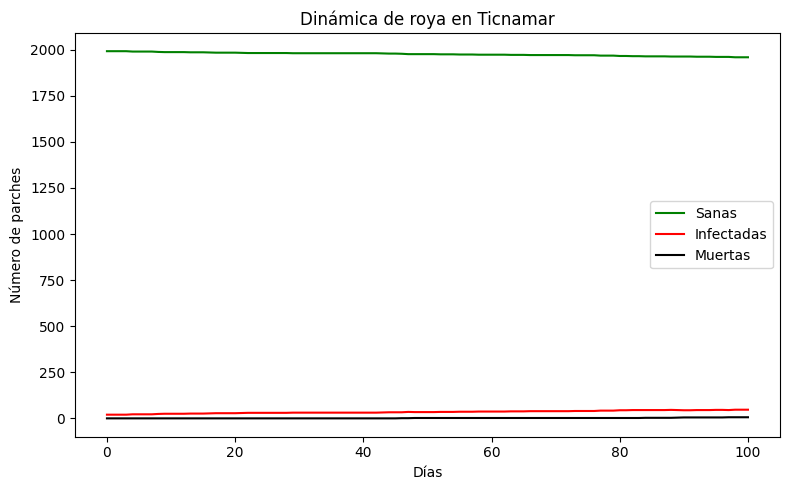


¡Simulaciones completadas para las 3 localidades!


In [ ]:
# 0) Instala Mesa si hace falta
# !pip install mesa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# 1) Carga y limpieza
CSV_PATH = 'datos_meteorologia_limpio_tres_localidades.csv'
df_all = (
    pd.read_csv(CSV_PATH)
      .dropna(subset=[
          'Temperatura del Aire ºC',
          'Humedad Relativa %',
          'Presión Atmosférica mbar',
          'Radiación Solar Mj/m²',
          'Velocidad de Viento km/h',
          'Localidad'
      ])
)
localidades = df_all['Localidad'].unique()

# 2) Parche de orégano
class OreganoPatch(Agent):
    def __init__(self, uid, model, pos):
        super().__init__(uid, model)
        self.pos = pos
        self.state = 0       # 0=vacío,1=sano,2=infectado,3=muerto
        self.days_inf = 0

    def step(self):
        if self.state == 2:
            self.days_inf += 1
            # mortalidad crónica
            idx = min(self.days_inf-1, len(self.model.mort_matrix)-1)
            if self.random.random() < self.model.mort_matrix[idx]:
                self.state = 3
                return
            # propagar
            for nb in self.model.get_neighbors_in_radius(self.pos, self.model.infection_radius):
                if nb.state == 1 and self.random.random() < self.model.current_rate:
                    nb.state = 2
                    nb.days_inf = 0

# 3) Modelo de Mesa
class OreganoModel(Model):
    def __init__(self, climate_df, localidad,
                 width=50, height=50, density=0.8, init_inf=0.01,
                 T_opt=20., sigma_T=3., H50=8., n_hill=3., r_max=0.7,
                 infection_radius=2., thresh_days=30,
                 base_mort=0.001, max_mort=0.1,
                 sim_days=100): #tiempo de la simulacion
        super().__init__()
        # filtrar datos
        self.climate = climate_df[climate_df['Localidad']==localidad].reset_index(drop=True)
        self.clim_len = len(self.climate)
        self.SIM_DAYS = sim_days
        self.current_day = 0
        # parámetros
        self.width = width; self.height = height
        self.density = density; self.init_inf = init_inf
        self.T_opt = T_opt; self.sigma_T = sigma_T
        self.H50 = H50; self.n_hill = n_hill; self.r_max = r_max
        self.infection_radius = infection_radius
        # promedio climático
        self.static_vals = self.climate[[
            'Temperatura del Aire ºC','Humedad Relativa %',
            'Presión Atmosférica mbar','Radiación Solar Mj/m²',
            'Velocidad de Viento km/h'
        ]].mean().values
        # matriz mortalidad crónica
        days = np.arange(1, thresh_days*2 + 1)
        probs = base_mort * (days/thresh_days)
        probs = np.clip(probs, 0, max_mort)
        self.mort_matrix = np.concatenate([np.zeros(thresh_days), probs[thresh_days:]])
        # grid y scheduler
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        # instanciar parches
        uid = 0
        for x in range(width):
            for y in range(height):
                p = OreganoPatch(uid, self, (x,y))
                self.grid.place_agent(p, (x,y))
                self.schedule.add(p)
                if self.random.random() < density:
                    p.state = 1
                uid += 1
        # infecciones iniciales
        plants = [a for a in self.schedule.agents if a.state==1]
        k0 = max(1, int(len(plants)*init_inf))
        for p in self.random.sample(plants, k0):
            p.state = 2; p.days_inf = 0
        # recolector
        self.datacollector = DataCollector(
            model_reporters={
                "Sanas":     lambda m: sum(a.state==1 for a in m.schedule.agents),
                "Infectadas":lambda m: sum(a.state==2 for a in m.schedule.agents),
                "Muertas":   lambda m: sum(a.state==3 for a in m.schedule.agents),
                "Tasa":      lambda m: m.current_rate
            }
        )
        # primera tasa y colección
        self.update_rate(); self.datacollector.collect(self)

    def get_neighbors_in_radius(self, pos, radius):
        x,y = pos; neigh=[]
        for dx in range(-int(radius), int(radius)+1):
            for dy in range(-int(radius), int(radius)+1):
                nx,ny = x+dx, y+dy
                if 0<=nx<self.width and 0<=ny<self.height and (dx,dy)!=(0,0):
                    if np.hypot(dx,dy)<=radius:
                        neigh.extend(self.grid.get_cell_list_contents([(nx,ny)]))
        return neigh

    def rate_of_infection(self, temp, hum, pres, rad, wind):
        tf = np.exp(-((temp-self.T_opt)**2)/(2*self.sigma_T**2))
        hr = (hum/self.H50)**self.n_hill; hf = hr/(1+hr)
        pf = np.exp(-((pres-705.)**2)/(2*5.0**2))
        rf = (rad/15.)/(1+rad/15.)
        wf = 1/(1+wind/5.)
        return np.clip(self.r_max*tf*hf*pf*rf*wf, 0, 1)

    def update_rate(self):
        if self.current_day < self.clim_len:
            row = self.climate.iloc[self.current_day]
            vals = [
                row['Temperatura del Aire ºC'],
                row['Humedad Relativa %'],
                row['Presión Atmosférica mbar'],
                row['Radiación Solar Mj/m²'],
                row['Velocidad de Viento km/h']
            ]
        else:
            vals = self.static_vals
        self.current_rate = self.rate_of_infection(*vals)

    def step(self):
        self.update_rate()
        self.schedule.step()
        self.datacollector.collect(self)
        self.current_day += 1

# 4) Ejecuta y grafica por localidad
for loc in localidades:
    print(f"\n>>> {loc} <<<")
    m = OreganoModel(df_all, loc, sim_days=100)
    for _ in range(m.SIM_DAYS):
        m.step()
    res = m.datacollector.get_model_vars_dataframe()

    plt.figure(figsize=(8,5))
    plt.plot(res['Sanas'],     label='Sanas',    c='green')
    plt.plot(res['Infectadas'],label='Infectadas',c='red')
    plt.plot(res['Muertas'],   label='Muertas',  c='black')
    plt.title(f"Dinámica de roya en {loc}")
    plt.xlabel("Días"); plt.ylabel("Número de parches")
    plt.legend(); plt.tight_layout()
    plt.show()

print("\n¡Simulaciones completadas para las 3 localidades!")


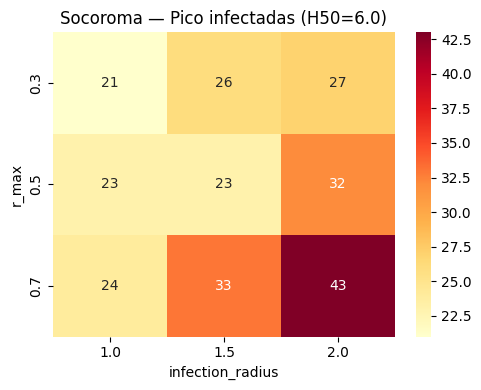

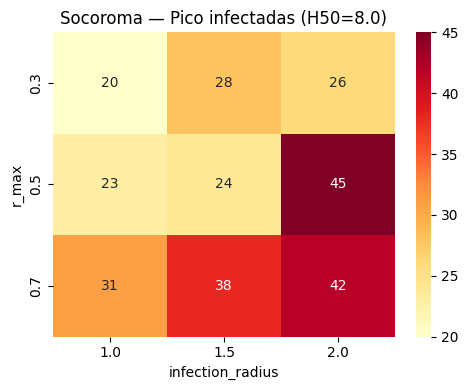

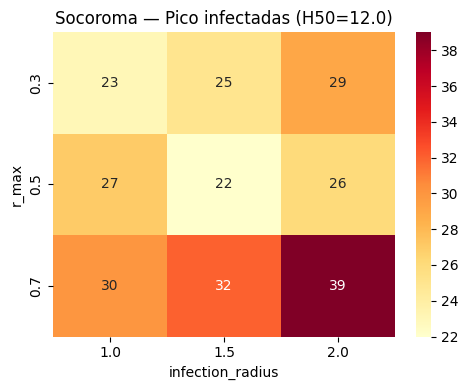

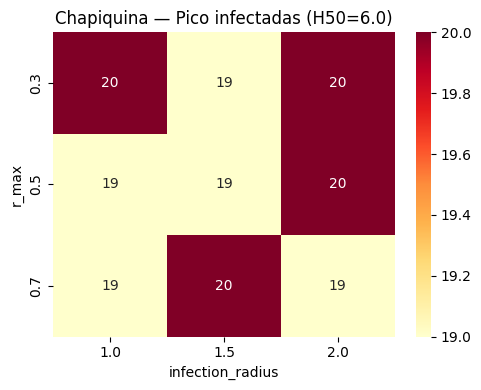

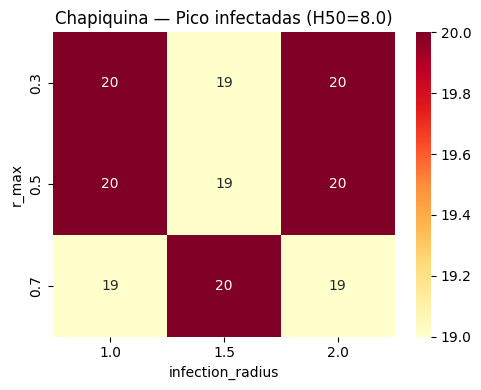

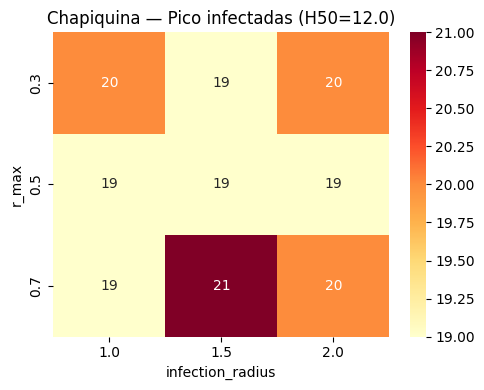

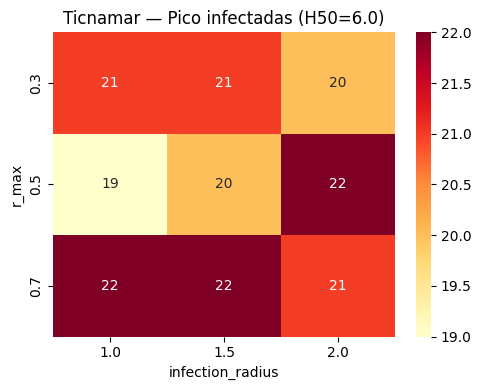

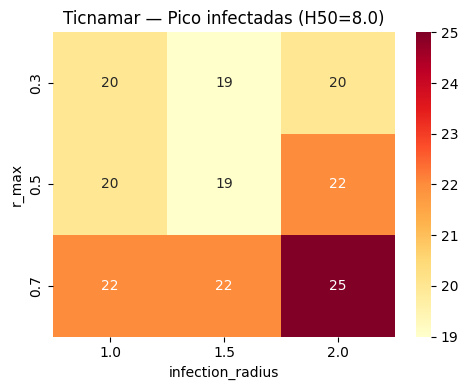

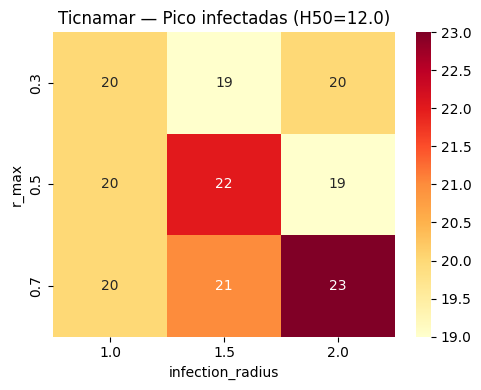

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.spatial.distance import cdist
import seaborn as sns

# 1) Carga el CSV combinado y limpia columnas
CSV_PATH = 'datos_meteorologia_limpio_tres_localidades.csv'
df_all = pd.read_csv(CSV_PATH)
df_all.columns = df_all.columns.str.strip()
df_all = df_all.dropna(subset=[
    'Temperatura del Aire ºC',
    'Humedad Relativa %',
    'Presión Atmosférica mbar',
    'Radiación Solar Mj/m²',
    'Velocidad de Viento km/h',
    'Localidad'
])

# --- Parámetros fijos del modelo ---
GRID_H, GRID_W    = 50, 50
PLANT_DENSITY     = 0.8
INITIAL_INF_FRAC  = 0.01
T_opt, sigma_T    = 20.0, 3.0
n_hill            = 3.0
r_max_vals        = [0.3, 0.5, 0.7]
H50_vals          = [6.0, 8.0, 12.0]
radius_vals       = [1.0, 1.5, 2.0]

# Parámetros ambientales (fijos para presión, radiación y viento)
P_opt, sigma_P   = 705.0, 5.0
R50, W50         = 15.0, 5.0

# Mortalidad crónica
threshold_days   = 30
base_mortality   = 0.001
max_mortality    = 0.1

def run_model(df_loc, r_max, H50, infection_radius):
    n_days = len(df_loc)
    # Inicializar grilla y estado
    state    = np.zeros((GRID_H, GRID_W), int)
    days_inf = np.zeros_like(state)
    mask     = np.random.rand(GRID_H, GRID_W) < PLANT_DENSITY
    state[mask] = 1
    # Infectar semilla
    healthy_idxs = np.argwhere(state == 1)
    k0 = max(1, int(len(healthy_idxs) * INITIAL_INF_FRAC))
    init = healthy_idxs[np.random.choice(len(healthy_idxs), k0, replace=False)]
    for (r, c) in init:
        state[r, c] = 2

    H_hist, I_hist, D_hist = [], [], []
    coords = np.dstack(np.indices(state.shape)).reshape(-1,2)

    for day in range(n_days):
        row  = df_loc.iloc[day]
        # Extraer variables diarias
        temp = row['Temperatura del Aire ºC']
        hum  = row['Humedad Relativa %']
        pres = row['Presión Atmosférica mbar']
        rad  = row['Radiación Solar Mj/m²']
        wind = row['Velocidad de Viento km/h']

        # Tasa de infección multivariable
        tf = np.exp(-((temp - T_opt)**2) / (2 * sigma_T**2))
        hr = (hum / H50)**n_hill
        hf = hr / (1 + hr)
        pf = np.exp(-((pres - P_opt)**2) / (2 * sigma_P**2))
        rf = (rad / R50) / (1 + rad / R50)
        wf = 1 / (1 + wind / W50)
        rate = np.clip(r_max * tf * hf * pf * rf * wf, 0, 1)

        # Registrar estados
        H_hist.append((state == 1).sum())
        I_hist.append((state == 2).sum())
        D_hist.append((state == 3).sum())

        # Propagación
        for (r, c) in np.argwhere(state == 2):
            dists    = cdist([(r, c)], coords).reshape(state.shape)
            mask_inf = (dists <= infection_radius) & (state == 1)
            rnd      = np.random.rand(GRID_H, GRID_W)
            new_inf  = (rnd < rate) & mask_inf
            state[new_inf]    = 2
            days_inf[new_inf] = 0

        # Aumentar días infectado
        days_inf[state == 2] += 1

        # Mortalidad crónica
        mort_prob = np.where(
            days_inf >= threshold_days,
            np.clip(base_mortality * (days_inf / threshold_days), 0, max_mortality),
            0.0
        )
        die = (np.random.rand(GRID_H, GRID_W) < mort_prob) & (state == 2)
        state[die] = 3

    return H_hist, I_hist, D_hist

# 5) Para cada localidad y cada H50, dibujar un heatmap de picos vs r_max y radius
for loc in df_all['Localidad'].unique():
    df_loc = df_all[df_all['Localidad'] == loc].reset_index(drop=True)
    for H50_val in H50_vals:
        records = []
        for r_m, rad in product(r_max_vals, radius_vals):
            _, I_hist, _ = run_model(df_loc, r_m, H50_val, rad)
            records.append({
                'r_max': r_m,
                'radius': rad,
                'peak': max(I_hist)
            })
        dfm = (
            pd.DataFrame(records)
              .pivot(index='r_max', columns='radius', values='peak')
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(dfm, annot=True, fmt='d', cmap='YlOrRd')
        plt.title(f'{loc} — Pico infectadas (H50={H50_val})')
        plt.xlabel('infection_radius')
        plt.ylabel('r_max')
        plt.tight_layout()
        plt.show()



=== Localidad: Socoroma ===


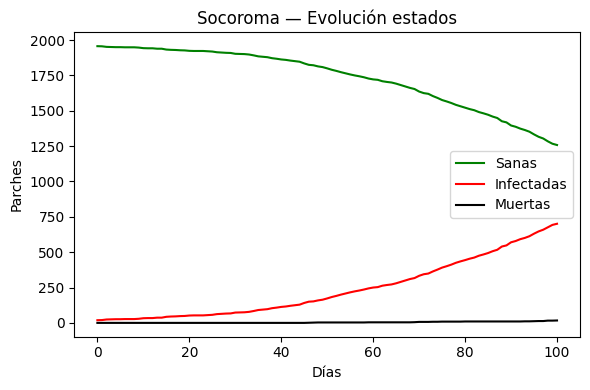

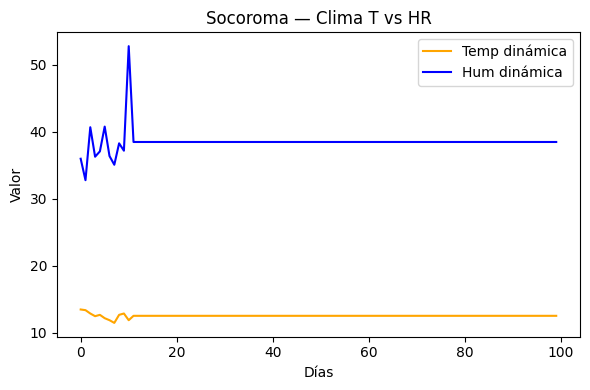

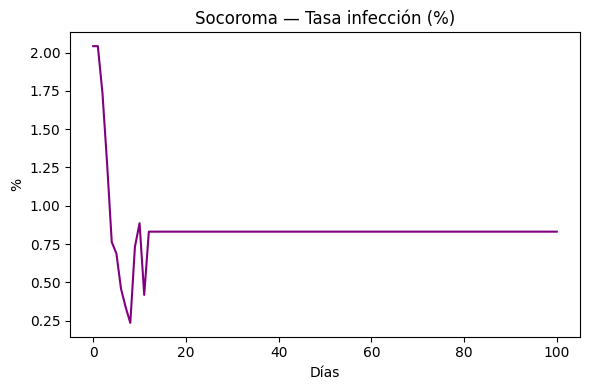

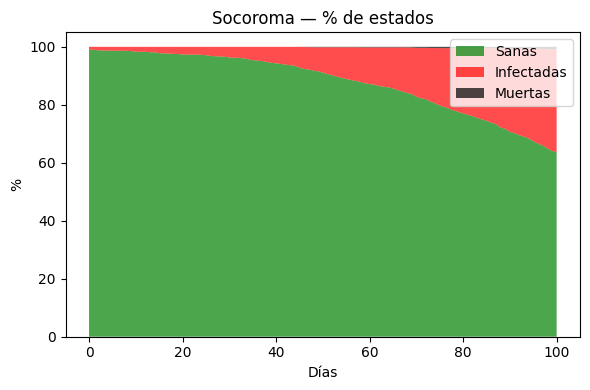

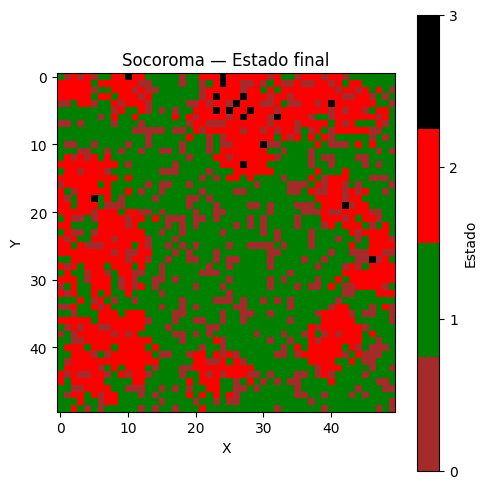

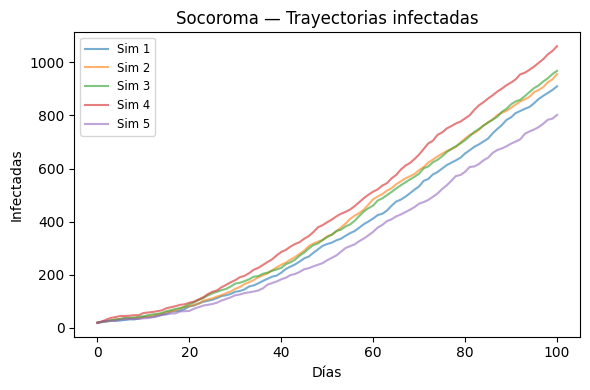

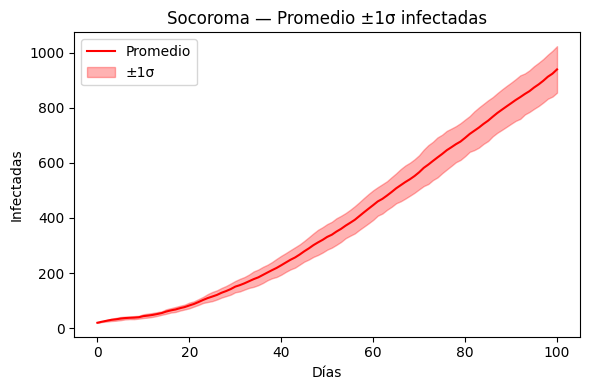


=== Localidad: Chapiquina ===


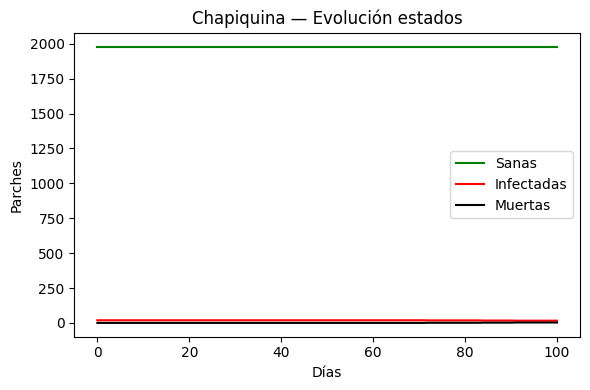

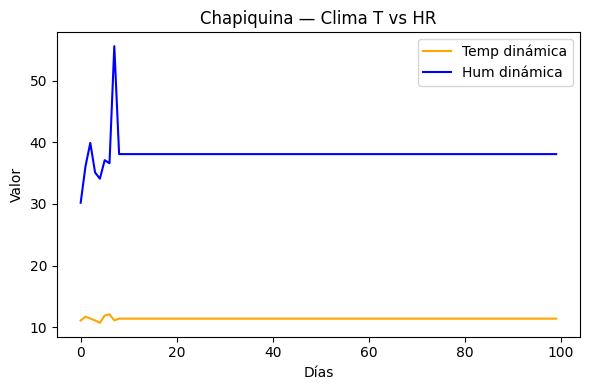

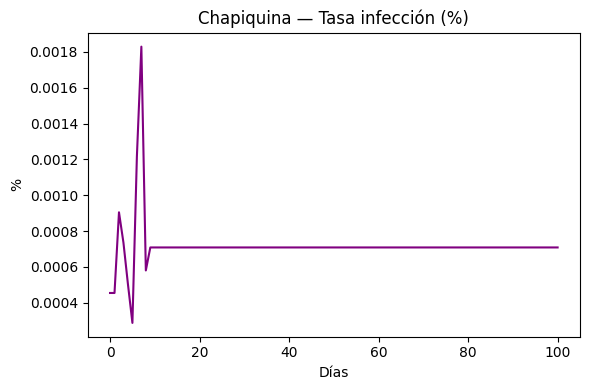

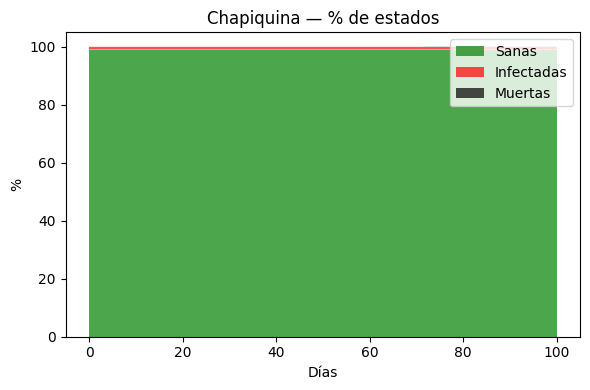

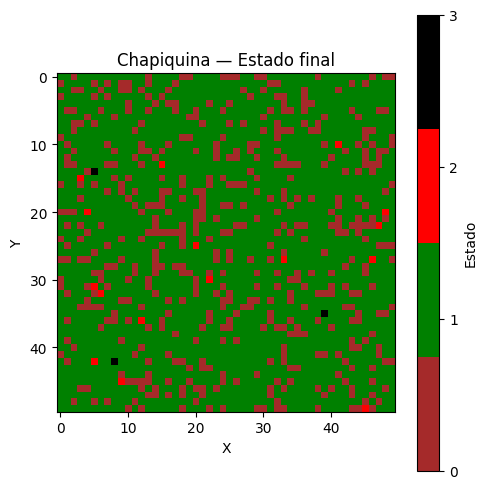

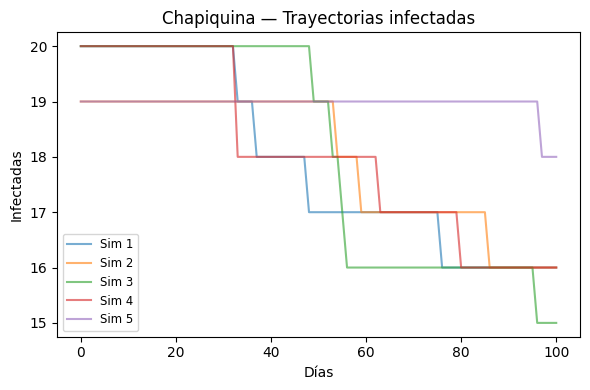

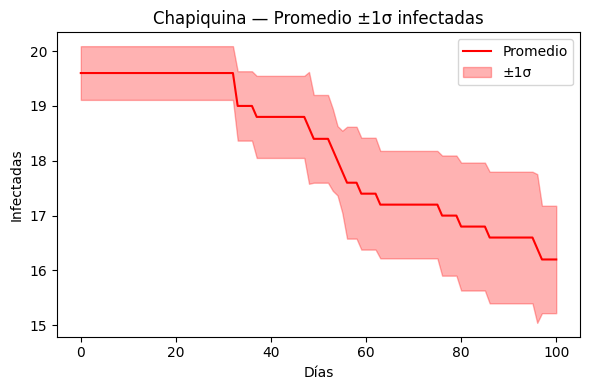


=== Localidad: Ticnamar ===


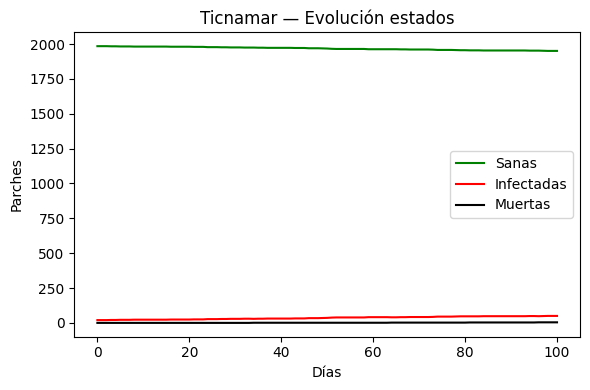

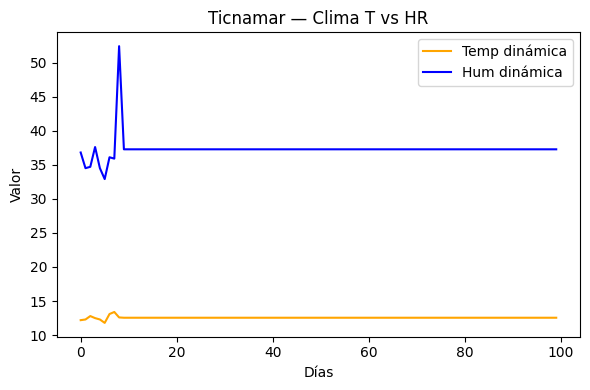

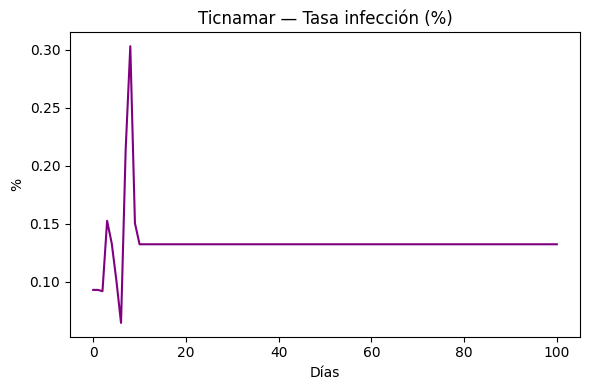

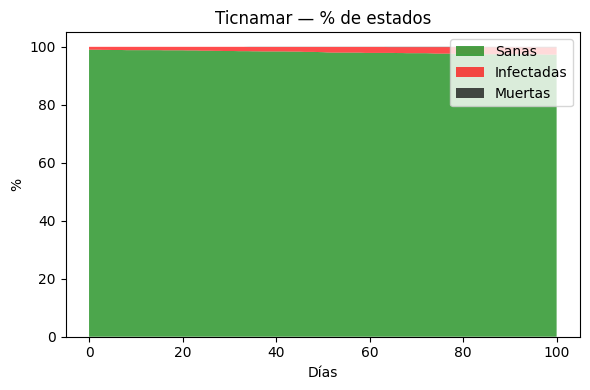

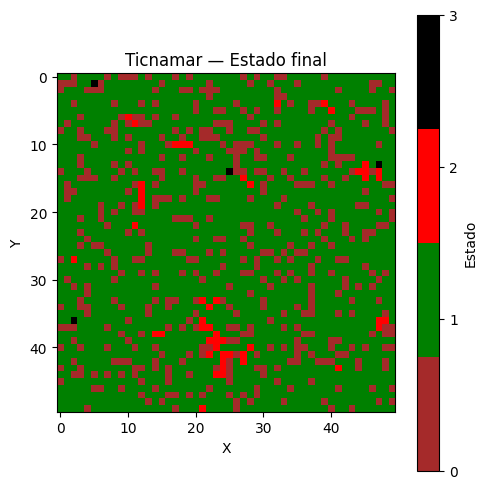

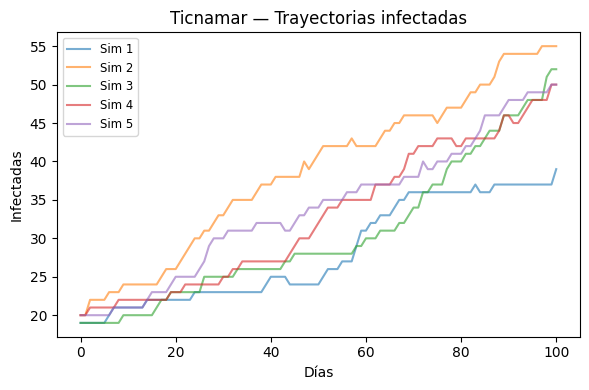

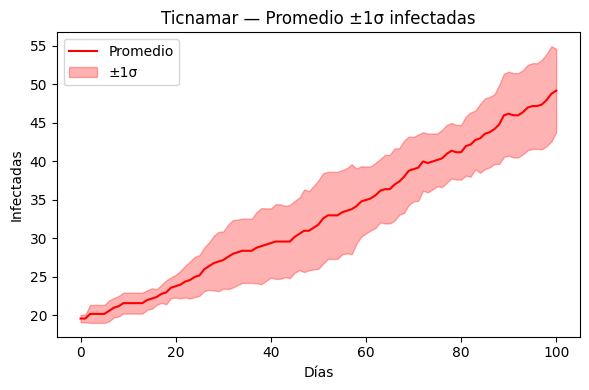

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# 1) Carga y limpieza de datos
CSV_PATH = 'datos_meteorologia_limpio_tres_localidades.csv'
df_all = (
    pd.read_csv(CSV_PATH)
      .dropna(subset=[
          'Temperatura del Aire ºC',
          'Humedad Relativa %',
          'Presión Atmosférica mbar',
          'Radiación Solar Mj/m²',
          'Velocidad de Viento km/h',
          'Localidad'
      ])
)
localidades = df_all['Localidad'].unique()

# 2) Agente: parche de orégano
class OreganoPatch(Agent):
    def __init__(self, uid, model, pos):
        super().__init__(uid, model)
        self.pos = pos
        self.state = 0        # 0=vacío,1=sano,2=infectado,3=muerto
        self.days_inf = 0

    def step(self):
        if self.state == 2:
            self.days_inf += 1
            # mortalidad crónica
            idx = min(self.days_inf-1, len(self.model.mort_matrix)-1)
            if self.random.random() < self.model.mort_matrix[idx]:
                self.state = 3
                return
            # propagación
            for nb in self.model.get_neighbors_in_radius(self.pos, self.model.infection_radius):
                if nb.state == 1 and self.random.random() < self.model.current_rate:
                    nb.state = 2
                    nb.days_inf = 0

# 3) Modelo Mesa
class OreganoModel(Model):
    def __init__(self, climate_df, localidad,
                 width=50, height=50, density=0.8, init_inf=0.01,
                 T_opt=20., sigma_T=3., H50=8., n_hill=3., r_max=0.7,
                 infection_radius=2., thresh_days=30,
                 base_mort=0.001, max_mort=0.1, sim_days=100):
        super().__init__()
        # Filtrar datos por localidad
        self.climate = climate_df[climate_df['Localidad']==localidad].reset_index(drop=True)
        self.clim_len = len(self.climate)
        self.SIM_DAYS = sim_days
        self.current_day = 0

        # Parámetros del modelo
        self.width = width; self.height = height
        self.density = density; self.init_inf = init_inf
        self.T_opt = T_opt; self.sigma_T = sigma_T
        self.H50 = H50; self.n_hill = n_hill; self.r_max = r_max
        self.infection_radius = infection_radius

        # Valores promedio para clima estático
        self.static_vals = self.climate[[
            'Temperatura del Aire ºC',
            'Humedad Relativa %',
            'Presión Atmosférica mbar',
            'Radiación Solar Mj/m²',
            'Velocidad de Viento km/h'
        ]].mean().values

        # Matriz de mortalidad crónica
        days = np.arange(1, thresh_days*2 + 1)
        probs = base_mort * (days / thresh_days)
        probs = np.clip(probs, 0, max_mort)
        self.mort_matrix = np.concatenate([
            np.zeros(thresh_days),
            probs[thresh_days:]
        ])

        # Grid y scheduler
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)

        # Crear parches
        uid = 0
        for x in range(width):
            for y in range(height):
                p = OreganoPatch(uid, self, (x,y))
                self.grid.place_agent(p, (x,y))
                self.schedule.add(p)
                if self.random.random() < density:
                    p.state = 1
                uid += 1

        # Infectar fracción inicial
        plants = [a for a in self.schedule.agents if a.state==1]
        k0 = max(1, int(len(plants) * init_inf))
        for p in self.random.sample(plants, k0):
            p.state = 2; p.days_inf = 0

        # DataCollector: estados y tasa
        self.datacollector = DataCollector(
            model_reporters={
                "Sanas":     lambda m: sum(a.state==1 for a in m.schedule.agents),
                "Infectadas":lambda m: sum(a.state==2 for a in m.schedule.agents),
                "Muertas":   lambda m: sum(a.state==3 for a in m.schedule.agents),
                "Tasa":      lambda m: m.current_rate
            }
        )
        self.update_rate(); self.datacollector.collect(self)

    def get_neighbors_in_radius(self, pos, radius):
        x,y = pos; neigh=[]
        for dx in range(-int(radius), int(radius)+1):
            for dy in range(-int(radius), int(radius)+1):
                nx, ny = x+dx, y+dy
                if 0<=nx<self.width and 0<=ny<self.height and (dx,dy)!=(0,0):
                    if np.hypot(dx,dy) <= radius:
                        neigh.extend(self.grid.get_cell_list_contents([(nx,ny)]))
        return neigh

    def rate_of_infection(self, temp, hum, pres, rad, wind):
        tf = np.exp(-((temp - self.T_opt)**2)/(2*self.sigma_T**2))
        hr = (hum/self.H50)**self.n_hill; hf = hr/(1+hr)
        pf = np.exp(-((pres-705.)**2)/(2*5.0**2))
        rf = (rad/15.)/(1+rad/15.)
        wf = 1/(1+wind/5.)
        return np.clip(self.r_max * tf * hf * pf * rf * wf, 0, 1)

    def update_rate(self):
        if self.current_day < self.clim_len:
            row = self.climate.iloc[self.current_day]
            vals = [
                row['Temperatura del Aire ºC'],
                row['Humedad Relativa %'],
                row['Presión Atmosférica mbar'],
                row['Radiación Solar Mj/m²'],
                row['Velocidad de Viento km/h']
            ]
        else:
            vals = self.static_vals
        self.current_rate = self.rate_of_infection(*vals)

    def step(self):
        self.update_rate()
        self.schedule.step()
        self.datacollector.collect(self)
        self.current_day += 1

# 4) Función para graficar grid final
def plot_grid_state(model, title="Estado final"):
    import matplotlib.colors as mcolors
    grid = np.zeros((model.height, model.width))
    for a in model.schedule.agents:
        x,y = a.pos
        grid[y,x] = a.state
    cmap = mcolors.ListedColormap(['brown','green','red','black'])
    plt.figure(figsize=(5,5))
    plt.imshow(grid, cmap=cmap)
    plt.title(title)
    plt.colorbar(ticks=[0,1,2,3], label='Estado')
    plt.xlabel('X'); plt.ylabel('Y')
    plt.tight_layout(); plt.show()

# 5) Ejecutar y graficar 7 paneles por localidad
N_SIM = 5
for loc in localidades:
    print(f"\n=== Localidad: {loc} ===")
    # Simulación principal
    m = OreganoModel(df_all, loc, sim_days=100)
    for _ in range(m.SIM_DAYS):
        m.step()
    res = m.datacollector.get_model_vars_dataframe()

    # Clima dinámico y promedio (solo T y HR para graficar)
    clim = df_all[df_all['Localidad']==loc].reset_index(drop=True)
    static = clim[['Temperatura del Aire ºC','Humedad Relativa %']].mean().values
    temp_dyn = np.concatenate([clim['Temperatura del Aire ºC'].values,
                               np.full(100-clim.shape[0], static[0])])
    hum_dyn  = np.concatenate([clim['Humedad Relativa %'].values,
                               np.full(100-clim.shape[0], static[1])])

    # Múltiples simulaciones
    trajectories = []
    for i in range(N_SIM):
        mi = OreganoModel(df_all, loc, sim_days=100)
        for _ in range(mi.SIM_DAYS):
            mi.step()
        trajectories.append(mi.datacollector.get_model_vars_dataframe()['Infectadas'].values)
    traj = np.array(trajectories)
    mean_traj = traj.mean(axis=0)
    std_traj  = traj.std(axis=0)

    # 1) Evolución de estados
    plt.figure(figsize=(6,4))
    plt.plot(res['Sanas'],    c='green', label='Sanas')
    plt.plot(res['Infectadas'],c='red',   label='Infectadas')
    plt.plot(res['Muertas'],  c='black', label='Muertas')
    plt.title(f"{loc} — Evolución estados")
    plt.xlabel("Días"); plt.ylabel("Parches")
    plt.legend(); plt.tight_layout(); plt.show()

    # 2) Clima dinámico vs promedio
    plt.figure(figsize=(6,4))
    plt.plot(temp_dyn, c='orange', label='Temp dinámica')
    plt.plot(hum_dyn,  c='blue',   label='Hum dinámica')
    plt.title(f"{loc} — Clima T vs HR")
    plt.xlabel("Días"); plt.ylabel("Valor")
    plt.legend(); plt.tight_layout(); plt.show()

    # 3) Tasa de infección diaria
    plt.figure(figsize=(6,4))
    plt.plot(res['Tasa'] * 100, c='purple')
    plt.title(f"{loc} — Tasa infección (%)")
    plt.xlabel("Días"); plt.ylabel("%")
    plt.tight_layout(); plt.show()

    # 4) Proporción de estados (%)
    total = res['Sanas'] + res['Infectadas'] + res['Muertas']
    plt.figure(figsize=(6,4))
    plt.stackplot(res.index,
                  res['Sanas']/total*100,
                  res['Infectadas']/total*100,
                  res['Muertas']/total*100,
                  labels=['Sanas','Infectadas','Muertas'],
                  colors=['green','red','black'], alpha=0.7)
    plt.title(f"{loc} — % de estados")
    plt.xlabel("Días"); plt.ylabel("%")
    plt.legend(loc='upper right'); plt.tight_layout(); plt.show()

    # 5) Estado final del grid
    plot_grid_state(m, f"{loc} — Estado final")

    # 6) Trayectorias individuales
    plt.figure(figsize=(6,4))
    for i in range(N_SIM):
        plt.plot(traj[i], alpha=0.6, label=f"Sim {i+1}")
    plt.title(f"{loc} — Trayectorias infectadas")
    plt.xlabel("Días"); plt.ylabel("Infectadas")
    plt.legend(fontsize='small'); plt.tight_layout(); plt.show()

    # 7) Promedio ±1σ
    plt.figure(figsize=(6,4))
    plt.plot(mean_traj, c='red', label='Promedio')
    plt.fill_between(range(len(mean_traj)),
                     mean_traj-std_traj,
                     mean_traj+std_traj,
                     color='red', alpha=0.3, label='±1σ')
    plt.title(f"{loc} — Promedio ±1σ infectadas")
    plt.xlabel("Días"); plt.ylabel("Infectadas")
    plt.legend(); plt.tight_layout(); plt.show()
